In [1]:
import numpy as np
import qutip
from qze.dimer import DimerParameters, get_c_ops, get_H_S, state_to_yz_bloch
from qze.dimer_gutzwiller_mc import DimerGutzwillerMCParameters
from pickle import load
import matplotlib.pyplot as plt

In [2]:
lambdas = [[.5, .5], [.5, 1.5], [1.5, .5]]
ntraj_list= [10**5]
omega_S_list = [1]

T_list = [20]
# t_eval_list = [np.array([T]) for T in T_list]
t_eval_list = [np.linspace(T/2, T, 21) for T in T_list]

# solver = "trsolve"
solver = "mcsolve"
# solver = "gutzwiller"
if solver == "mcsolve":
    dt_list = [None]
elif solver == "trsolve" or solver == "gutzwiller":
    dt_list = [0.01]

no_click = False

psi0_list = [qutip.tensor(qutip.basis(2, 1), qutip.basis(2, 1))]


sim_list = [DimerParameters(omega_S_list[0],
                            lmbd_1,
                            lmbd_2,
                            get_H_S(omega_S_list[0]),
                            get_c_ops(lmbd_1, lmbd_2, omega_S_list[0]),
                            psi0_list[0],
                            t_eval_list[0],
                            ntraj_list[0],
                            solver,
                            dt_list[0],
                            no_click)
            for lmbd_1, lmbd_2 in lambdas]

In [3]:
nwalk = 10**7
T = 20
dt = .01
# lambdas = [[.5, .5], [.5, 1.5], [1.5, .5]]
omega_S = 1

walk_pos0 = np.array(nwalk * [[np.pi, np.pi]])

sim_list_gutz = [DimerGutzwillerMCParameters(omega_S,
                                             lmbd_1,
                                             lmbd_2,
                                             walk_pos0,
                                             dt,
                                             T,
                                             nwalk)
                 for lmbd_1, lmbd_2 in lambdas]

In [4]:
data = []

for sim in sim_list:
    f = open(f"data/{str(sim)}.pkl", "rb")
    data.append(load(f))
    f.close()

In [5]:
# coords_full = []
# for i, sim in enumerate(sim_list):
#     # All saved states
#     states_full = np.array(data[i][1].states, dtype=object).flatten()

#     # Only final states
#     # states_full = np.array(data[i][1].states, dtype=object)[:,-1].flatten()

#     coords_full.append(state_to_yz_bloch(states_full))

In [6]:
walk_positions = []

for sim in sim_list_gutz:
    f = open(f"data/{str(sim)}.pkl", "rb")
    d = load(f)
    f.close()
    walk_positions.append(d[1])

walk_positions = np.array(walk_positions)

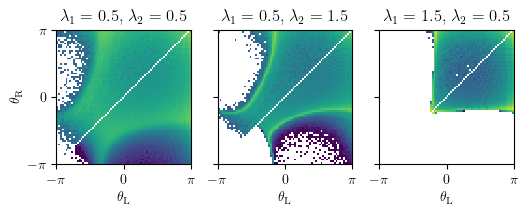

In [7]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 72
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, sim in enumerate(sim_list):
    tl = data[i]['bloch_coords'][:-1,0,1]
    tr = data[i]['bloch_coords'][:-1,1,1]

    hist_full, edges_l, edges_r = np.histogram2d(tl,
                                                 tr,
                                                 bins=bins,
                                                 range=binning_range,
                                                 density=True)
    
    hist_gutz, edges_l, edges_r = np.histogram2d(walk_positions[i][:, 0],
                                                 walk_positions[i][:, 1],
                                                 bins=bins,
                                                 range=binning_range,
                                                 density=True)
    
    hist_comp = np.zeros_like(hist_full)
    for j in np.arange(len(hist_comp)):
        for k in np.arange(j+1, len(hist_comp[j]), 1):
            hist_comp[k, j] = (hist_full[j, k] + hist_full[k, j]) / 2
            hist_comp[j, k] = (hist_gutz[j, k] + hist_gutz[k, j]) / 2

    axs[i].pcolormesh(edges_l, edges_r, hist_comp,
                      norm="log",
                      vmin=hist_gutz[np.nonzero(hist_gutz)].min(),
                      vmax=hist_gutz.max())

    # centers_l = (edges_l[1:] + edges_l[:-1]) / 2
    # centers_r = (edges_r[1:] + edges_r[:-1]) / 2   
    # axs[i].pcolormesh(centers_l, centers_r, hist_comp,
    #                   norm="log",
    #                   vmin=hist_gutz[np.nonzero(hist_gutz)].min(),
    #                   vmax=hist_gutz.max(),
    #                   shading='gouraud')

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_yticks(ticks)
    axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(rf"$\lambda_1 = {sim.lmbd_1}$, $\lambda_2 = {sim.lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L}$", ylabel=r"$\theta_\mathrm{R}$")
    axs[i].set(aspect='equal')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig("plots/dimer/dimer-full-gutz-p-infty-mc.pdf")

## Marginal

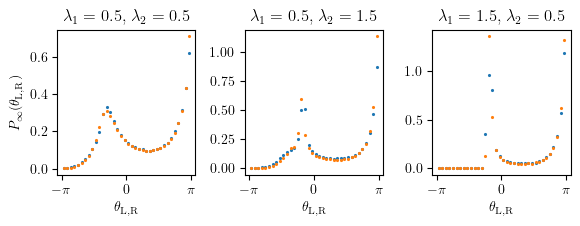

In [8]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 36
binning_range = [-np.pi, np.pi]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, sim in enumerate(sim_list):
    tl = data[i]['bloch_coords'][:-1,0,1]
    tr = data[i]['bloch_coords'][:-1,1,1]

    th_full = np.array([tl, tr]).flatten()
    th_gutz = walk_positions[i].flatten()

    marg_full, bin_edges = np.histogram(th_full,
                                        bins=bins,
                                        range=binning_range,
                                        density=True)
    marg_gutz, bin_edges = np.histogram(th_gutz,
                                        bins=bins,
                                        range=binning_range,
                                        density=True)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    axs[i].plot(bin_centers, marg_full,
                '.',
                label=r"Full MC")
    axs[i].plot(bin_centers, marg_gutz,
                '.',
                label=r"Gutz MC")

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    # axs[i].set_yticks(ticks)
    # axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(rf"$\lambda_1 = {sim.lmbd_1}$, $\lambda_2 = {sim.lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L, R}$", ylabel=r"$P_\infty(\theta_{\mathrm{L,R}})$")
    # axs[i].set(aspect='equal')
    # axs[i].legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()
plt.savefig("plots/dimer/dimer-full-gutz-p-infty-marg-mc.pdf")

## Edge

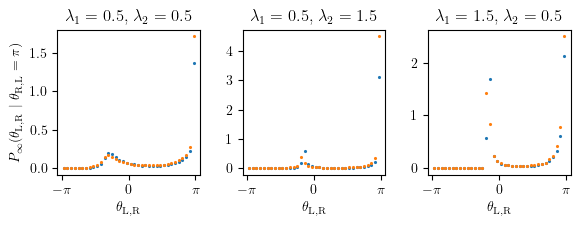

In [9]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 36
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, sim in enumerate(sim_list):
    tl = data[i]['bloch_coords'][:-1,0,1]
    tr = data[i]['bloch_coords'][:-1,1,1]

    hist_full, edges_l, edges_r = np.histogram2d(tl,
                                                 tr,
                                                 bins=bins,
                                                 range=binning_range,
                                                 density=True)
    
    hist_gutz, edges_l, edges_r = np.histogram2d(walk_positions[i][:, 0],
                                                 walk_positions[i][:, 1],
                                                 bins=bins,
                                                 range=binning_range,
                                                 density=True)

    bin_centers = (edges_l[:-1] + edges_l[1:]) / 2

    edge_full = (hist_full[-1] + hist_full[:, -1]) / 2
    edge_gutz = (hist_gutz[-1] + hist_gutz[:, -1]) / 2

    axs[i].plot(bin_centers, edge_full,
                '.',
                label=r"Full MC")
    axs[i].plot(bin_centers, edge_gutz,
                '.',
                label=r"Gutz MC")

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    # axs[i].set_yticks(ticks)
    # axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(rf"$\lambda_1 = {sim.lmbd_1}$, $\lambda_2 = {sim.lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L, R}$", ylabel=r"$P_\infty(\theta_{\mathrm{L,R}} \mid \theta_{\mathrm{R,L}}=\pi)$")
    # axs[i].set(aspect='equal')
    # axs[i].legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()
plt.savefig("plots/dimer/dimer-full-gutz-p-infty-edge-mc.pdf")

## Diagonal

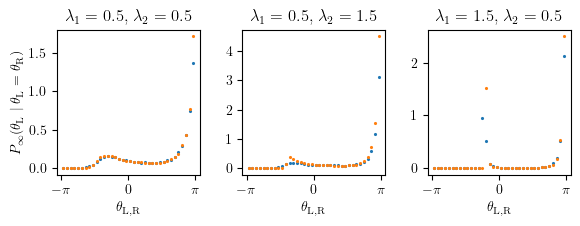

In [10]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 36
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, sim in enumerate(sim_list):
    tl = data[i]['bloch_coords'][:-1,0,1]
    tr = data[i]['bloch_coords'][:-1,1,1]

    hist_full, edges_l, edges_r = np.histogram2d(tl,
                                                 tr,
                                                 bins=bins,
                                                 range=binning_range,
                                                 density=True)
    
    hist_gutz, edges_l, edges_r = np.histogram2d(walk_positions[i][:, 0],
                                                 walk_positions[i][:, 1],
                                                 bins=bins,
                                                 range=binning_range,
                                                 density=True)

    bin_centers = (edges_l[:-1] + edges_l[1:]) / 2

    diag_full = np.diagonal(hist_full)
    diag_gutz = np.diagonal(hist_gutz)

    axs[i].plot(bin_centers, diag_full,
                '.',
                label=r"Full MC")
    axs[i].plot(bin_centers, diag_gutz,
                '.',
                label=r"Gutz MC")

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    # axs[i].set_yticks(ticks)
    # axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(rf"$\lambda_1 = {sim.lmbd_1}$, $\lambda_2 = {sim.lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L, R}$", ylabel=r"$P_\infty(\theta_{\mathrm{L}} \mid \theta_{\mathrm{L}}=\theta_{\mathrm{R}})$")
    # axs[i].set(aspect='equal')
    # axs[i].legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()
plt.savefig("plots/dimer/dimer-full-gutz-p-infty-diag-mc.pdf")